# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [2]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = './data/train.p'
testing_file = './data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_aug_train = [[[]]] # for augmentation
y_aug_train = [[[]]] # for augmentation
X_test, y_test = test['features'], test['labels']

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [3]:
### Replace each question mark with the appropriate value.
import numpy as np

# TODO: Number of training examples
n_train = len(X_train)

# TODO: Number of testing examples.
n_test = len(X_test)

# TODO: What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)
#print(y_train[39208])

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

38


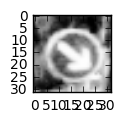

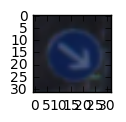

uint8


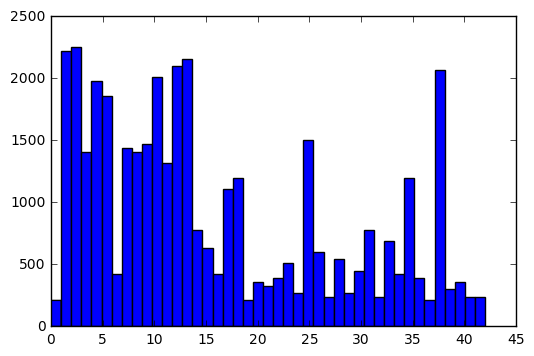

In [4]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
from skimage import color
from skimage import io
import cv2
# Visualizations will be shown in the notebook.
%matplotlib inline

import random


#convert image to grayscale, but retain shape by padding 
# A little complex function converting to YUV, then applying histogram back to RGB and finally to grayscale
# Surely easier method exists for what i'm trying to do
#grayscale conversion helper function
def image2Gray(image):
    
    img_yuv = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)

    # equalize the histogram of the Y channel
    img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])

    # convert the YUV image back to RGB format
    img_output = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)
    
    # convert back to grayscale with same shape
    image2 = cv2.cvtColor(img_output, cv2.COLOR_RGB2YUV)[:,:,0:1]
    return image2

#def image2GrayOld(image):
    
    # convert back to grayscale with same shape
    #image2 = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)[:,:,0:1]
    #return image2



def image2GrayArray (imageArray):
    equalizedArray = [] 
    for image in imageArray:
        equalizedArray.append(image2Gray(image))
    return equalizedArray
        

index = random.randint(0, len(X_train))
image = X_train[index].squeeze()
#print(image)
grayscaleimage = image2Gray(image)
#print(grayscaleimage)

plt.figure(figsize=(1,1))
plt.imshow(grayscaleimage[:, :, 0], cmap='gray')
plt.figure(figsize=(1,1))
plt.imshow(image)
print(y_train[index])
plt.show()
print(image.dtype)

# See a histogram of representation
counts, bins, bars = plt.hist(y_train[0:len(y_train)],len(np.unique(y_train)))
plt.show()



new length is 39209


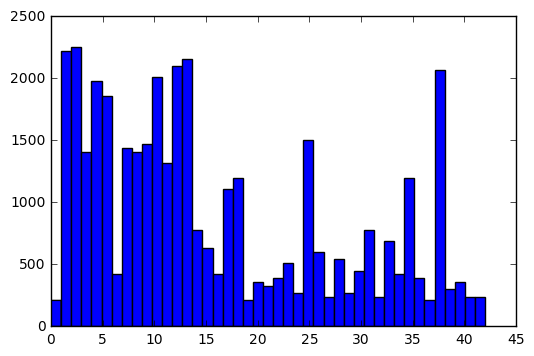

new length is 39209


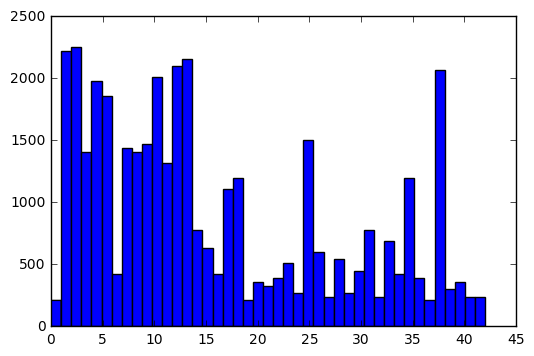

In [5]:
from scipy import ndimage

#Helper function to find maximum represented class
#Input labels - representing data in format of y_train
def findMaxClass(labels):
    #Use histogram (re-used from previous cell) to obtain the number of counts in each class
    #TODO hide plot
    counts, bins, bars = plt.hist(labels[0:len(labels)],len(np.unique(labels)))
    
    #Placeholders to find max count and max represented class
    maximum_representation = counts[0] 
    max_represented_class = 0
    i = 0
    
    for class_of_signal in counts:
        # We have a new maximum
        if(counts[i] > maximum_representation):
            maximum_representation = counts[i]
            max_represented_class = i
        i=i+1
        
    return maximum_representation, max_represented_class

# Get a list of classes and by how much they should be augmented
# Default argumentation value is set at 75%
# Mini hardcoding....We know that the X_train and y_train are in order, i.e. classes are represented in order
# and we use that here. However, if they're randomly ordered, then we'll have an issue with this code
# No time right now to make it more robust
def augment(X_train, y_train, X_aug_train, y_aug_train, percentile = 75):


    #Print the maximum represented class and count of the same
    max_rep, max_rep_class = findMaxClass(y_train)
    print(max_rep)
    print(max_rep_class)

    #Placeholders
    i = 0
    class_start_point = 0
    class_end_point = 0
    
    #Image manipulation counter
    counter = 0
   
    for class_of_signal in counts+1:
            if (class_of_signal >= percentile*max_rep/100):
                #Nothing to do since we have more than 75% 
                #But print class_start and endpoints
                class_end_point = class_start_point + class_of_signal - 1
                print("number of objects in class", i, "is ", class_of_signal-1)
                print ("Class starts at ", class_start_point, " and ends at ", class_end_point-1)

          
            else:
                # Class is under-represented
                under_rep = (percentile*max_rep/100 - class_of_signal)
                # Means we have to use a % augmentation
                
                class_end_point = class_start_point + class_of_signal - 1
               
                print("number of objects in class", i, "is ", class_of_signal-1)
                print ("Class starts at ", class_start_point, " and ends at ", class_end_point-1)
                print("and is under-represented by", under_rep)
                
                if(under_rep > class_of_signal):
                    print("augmenting all images")
                    print("Sending class for augmenting", int(round(class_of_signal-1)), "times")
                    
                    #TODO - ineffecient loop, change to generate same image y times instead of running
                    # through all items and re-iterating the same y times
                    for y in range(0, int(round((under_rep)/class_of_signal))):
                    
                        print("Pass ", y+1, "of ", int(round((under_rep)/class_of_signal)))
                        
                        temp_counter = 1
                    
                        #Loop to generate fake data
                        #print ("debug" , "from ", int(round((class_start_point))), "to, " , int(round(class_end_point-1)))
                        for x in range(int(round((class_start_point))), int(round(class_end_point-1))):
                            
                       
                            image = X_train[x].squeeze()

                            #Rotate image by a slight degree - 
                            rotated = ndimage.rotate(image, np.random.randint(-5,5),reshape=False)

                            counter += 1

                            X_aug_train = np.expand_dims(rotated, axis=0) 
                            X_train = np.concatenate((X_train, X_aug_train))
                            y_train = np.append(y_train, i)
                            
                            if(temp_counter % 100 == 0):
                                print (temp_counter, "done out of ", int(round(class_of_signal-1)))
                            temp_counter +=1
                        
                        # Outer loop (pass) incrementation
                        y = y+1
                    
                else:
                    pass
                    print("single augmentation technique")
                    
                    print("Sending class for augmenting", round(under_rep), "times")
                    
                    #Loop to generate fake data
                    for x in range(0, int(round(under_rep))):
                        rand_idx = np.random.randint(class_start_point, class_end_point-1)
                        image = X_train[rand_idx].squeeze()
                         
                        #Rotate image by a slight degree - 
                        rotated = ndimage.rotate(image, np.random.randint(-5,5),reshape=False)
                        
                        #print(rotated.shape)
                        
                        #X_aug_train = np.append(X_train, rotated)
                        
                        counter += 1
                        
                        X_aug_train = np.expand_dims(rotated, axis=0) 
                        X_train = np.concatenate((X_train, X_aug_train))
                        y_train = np.append(y_train, i)
                        
                        if(x % 100 == 0):
                            print (x, "done out of ", int(round(under_rep)))
                       
                        # See a histogram of new representation
                        #counts, bins, bars = plt.hist(y_train[0:len(y_train)],len(np.unique(y_train)))
                        #plt.show()
                       
                        #print (rotated.shape)
                        
                        #plt.subplot(121),plt.imshow(image),plt.title('Input')
                        #plt.subplot(122),plt.imshow(rotated),plt.title('Output')
                        #plt.show()
                        
                        #X_train = np.append(X_train, rotated)
                        #print(len(X_train))


            i=i+1
            # Set next class's starting point to current end point
            class_start_point = class_end_point
            
            #new_X = np.concatenate((X_train, new_X))
            #new_Y = np.concatenate((y_train, new_y)) 
    print("total images addes is ", counter)
    #return np.reshape(X_aug_train, (39228,3,3,2))
    return X_train, y_train

# Adapted from https://github.com/georgesung/traffic_sign_classification_german/blob/master/data_aug.py

def write_aug_set(new_file):

    # Create dict of new data, and write it to disk via pickle file
    new_data = {'features': X_train, 'labels': y_train}
    with open(new_file, mode='wb') as f:
        pickle.dump(new_data, f)
        print("Data saved")

#Debug run      
####################################################################
#
# Only run if data is not yet augmented, takes about 1 hour+ to augment 
#
########################################################################
#X_train, y_train = augment(X_train, y_train, X_aug_train, y_aug_train)
print("new length is", len(X_train))

counts, bins, bars = plt.hist(y_train[0:len(y_train)],len(np.unique(y_train)))
plt.show()

#Debug run      
####################################################################
#
# Only run if augmented data is not yet saved
#
########################################################################
#write_aug_set('./data/train_aug.p')
print("new length is", len(X_train))

counts, bins, bars = plt.hist(y_train[0:len(y_train)],len(np.unique(y_train)))
plt.show()



In [6]:
print ("Augmented training set is ", len(X_train))
print("# of augmented lable count", len(y_train)) #must match new training set


Augmented training set is  39209
# of augmented lable count 39209


Obviously some of the classes are under-represented. We'll use a "patch job" to find out which values are under-represented and augment them to get more data points

Split the training test into training and validation using the 80/20 rule


In [7]:
from sklearn.cross_validation import train_test_split

X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, train_size = 0.8)
print("Number of training examples =", len(X_train))
print("Number of validation examples =", len(X_validation))


C:\Users\ram\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Number of training examples = 31367
Number of validation examples = 7842



## Step 2: Design and Test a Model Architecture
Shuffle the training data.

In [8]:
from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train)

## Setup TensorFlow
The EPOCH and BATCH_SIZE values affect the training speed and model accuracy.

In [9]:
import tensorflow as tf

EPOCHS = 250                  
BATCH_SIZE = 128

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

In [10]:
from tensorflow.contrib.layers import flatten

def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # SOLUTION: Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # SOLUTION: Activation.
    conv1 = tf.nn.relu(conv1)
    
    #Hardcoded dropout
    conv1 = tf.nn.dropout(conv1,0.9)
    
    # SOLUTION: Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # SOLUTION: Activation.
    conv2 = tf.nn.relu(conv2)
      
    # SOLUTION: Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # SOLUTION: Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # SOLUTION: Activation.
    fc1    = tf.nn.relu(fc1)
   
    # SOLUTION: Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # SOLUTION: Activation.
    fc2    = tf.nn.relu(fc2)
    
    #Dropout layer 
    fc2 = tf.nn.dropout(fc2, keep_prob)
    
    # SOLUTION: Layer 5: Fully Connected. Input = 84. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

## Features and Labels
Train LeNet to classify Traffic signs data.
x is a placeholder for a batch of input images. y is a placeholder for a batch of output labels.
keep_prob is dropout probability

In [11]:
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32) # Dropout probability
one_hot_y = tf.one_hot(y, 43)                    

### Training Pipeline
Create a training pipeline that uses the model to classify Traffic Signs data.

In [12]:
rate = 0.0001

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

## Model Evaluation
Evaluate how well the loss and accuracy of the model for a given dataset.

In [13]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = image2GrayArray(X_data[offset:offset+BATCH_SIZE]), y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob:1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

## Train the Model
Run the training data through the training pipeline to train the model.
Before each epoch, shuffle the training set.
After each epoch, measure the loss and accuracy of the validation set.
Save the model after training.

In [13]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = image2GrayArray(X_train[offset:end]), y_train[offset:end]
            #sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob:0.5}) #with dropout
            
        validation_accuracy = evaluate(X_validation, y_validation)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './lenet')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.137

EPOCH 2 ...
Validation Accuracy = 0.386

EPOCH 3 ...
Validation Accuracy = 0.495

EPOCH 4 ...
Validation Accuracy = 0.572

EPOCH 5 ...
Validation Accuracy = 0.631

EPOCH 6 ...
Validation Accuracy = 0.710

EPOCH 7 ...
Validation Accuracy = 0.782

EPOCH 8 ...
Validation Accuracy = 0.811

EPOCH 9 ...
Validation Accuracy = 0.856

EPOCH 10 ...
Validation Accuracy = 0.888

EPOCH 11 ...
Validation Accuracy = 0.896

EPOCH 12 ...
Validation Accuracy = 0.905

EPOCH 13 ...
Validation Accuracy = 0.932

EPOCH 14 ...
Validation Accuracy = 0.931

EPOCH 15 ...
Validation Accuracy = 0.936

EPOCH 16 ...
Validation Accuracy = 0.944

EPOCH 17 ...
Validation Accuracy = 0.947

EPOCH 18 ...
Validation Accuracy = 0.950

EPOCH 19 ...
Validation Accuracy = 0.947

EPOCH 20 ...
Validation Accuracy = 0.947

EPOCH 21 ...
Validation Accuracy = 0.942

EPOCH 22 ...
Validation Accuracy = 0.961

EPOCH 23 ...
Validation Accuracy = 0.959

EPOCH 24 ...
Validation Accura

## Evaluate the Model
Once you are completely satisfied with your model, evaluate the performance of the model on the test set.
Be sure to only do this once!
If you were to measure the performance of your trained model on the test set, then improve your model, and then measure the performance of your model on the test set again, that would invalidate your test results. You wouldn't get a true measure of how well your model would perform against real data.

In [14]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.914


In [ ]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.

### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**

In [ ]:
### Generate additional data (OPTIONAL!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**

In [ ]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

In [ ]:
### Train your model here.
### Feel free to use as many code cells as needed.

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

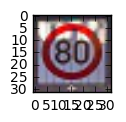

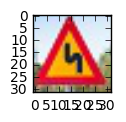

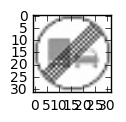

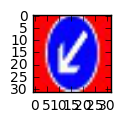

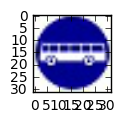

In [22]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
from scipy import misc

#read all image in the custom_images folder
for i in range(1,6):
    path = "./custom_images/" + str(i) + ".jpg"
    image = plt.imread(path)
    plt.figure(figsize=(1,1))
    plt.imshow(image)
    plt.show()


### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

Signs were chosen at random

1.jpg - easy sign - speed limit 80 km/h - classID = 5

2.jpg - relatively easy, but differently colored. The grayscale conversion should handle this - double curve, classID = 21

3.jpg - black and white sign with a cross indicating end of an area. Must be slightly difficult to handle - End of no passing by vehicles over 3.5 metric tons - classID = 42 

4.jpg - relatively easy, but has issues with size cropping and a red border = keep left, classID = 39

5.jpg - bonus, class of sign not found in the training set (actually part of german traffic signals, but image is from Indonesian signal) = bus lane = ClassID = ??? (no close match also found in existing data set)

In [1]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

own_images = []
#read all image in the custom_images folder
for i in range(1,6):
    path = "./custom_images/" + str(i) + ".jpg"
    image = plt.imread(path)
    plt.figure(figsize=(1,1))
    grayscaleimage = image2Gray(image) #What the input to our network will be
    plt.imshow(grayscaleimage[:, :, 0], cmap='gray')
    plt.show()
    own_images.append(image)
    
own_images_batch = np.reshape((own_images), (i, 32, 32,3))
#print(own_images_batch.shape)

#grayscaleimage = np.reshape(image2Gray(image), (1,32,32,1))
#own_images = np.empty([0, 32, 32, 1], dtype = np.int32)
#own_images = np.append(own_images, grayscaleimage, axis = 0)
#print(grayscaleimage.shape)


output = tf.argmax(logits, 1)

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    print(sess.run(output, feed_dict={x:image2GrayArray(own_images_batch), keep_prob:1.0}))

NameError: name 'plt' is not defined

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**

In [ ]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

own_images = []
#read all image in the custom_images folder
for i in range(1,6):
    path = "./custom_images/" + str(i) + ".jpg"
    image = plt.imread(path)
    plt.figure(figsize=(1,1))
    grayscaleimage = image2Gray(image) #What the input to our network will be
    plt.imshow(grayscaleimage[:, :, 0], cmap='gray')
    plt.show()
    own_images.append(image)
    
own_images_batch = np.reshape((own_images), (i, 32, 32,3))

top_predictions = tf.nn.top_k(logits, 3) # Limit to top 3

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    print(sess.run(top_predictions, feed_dict={x:image2GrayArray(own_images_batch), keep_prob:1.0}))

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.